# **Learning Rate Finder Explained| How to Choose the Best Learning Rate in PyTorch**

**Exponential Learning Rate Schedule**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [ ]:
transform=transforms.ToTensor()
train_data=torchvision.datasets.MNIST(root="./data",train=True,download=True,transform=transform)
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
train_iterator=DataLoader(train_data,batch_size=64,shuffle=True)

In [ ]:
len(train_iterator)

938

In [ ]:
class SmallCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(1,16,kernel_size=3,padding=1)
    self.relu=nn.ReLU()
    self.pool=nn.MaxPool2d(2,2)
    self.fc1=nn.Linear(16*14*14,10)
  def forward(self,x):
    x=self.pool(self.relu(self.conv1(x)))
    x=x.view(x.size(0),-1)
    out=self.fc1(x)
    return  out, x


In [ ]:
model=SmallCNN()

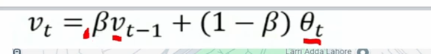

In [ ]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):

        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr=10, num_iter=100,
                   smooth_f=0.05, diverge_th=5):

        lrs = []
        losses = []
        best_loss = float('inf')
        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        iterator = IteratorWrapper(iterator)
        for iteration in range(num_iter):
            loss = self._train_batch(iterator)
            lrs.append(lr_scheduler.get_last_lr()[0])
            lr_scheduler.step()
            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
            if loss < best_loss:
                best_loss = loss
            losses.append(loss)
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break

        model.load_state_dict(torch.load('init_params.pt'))
        return lrs, losses

    def _train_batch(self, iterator):

        self.model.train()

        self.optimizer.zero_grad()
        x, y = iterator.get_batch()
        x = x.to(self.device)
        y = y.to(self.device)
        y_pred, _ = self.model(x)
        loss = self.criterion(y_pred, y)
        loss.backward()
        self.optimizer.step()
        return loss.item()


class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):

        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r
                for base_lr in self.base_lrs]


class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

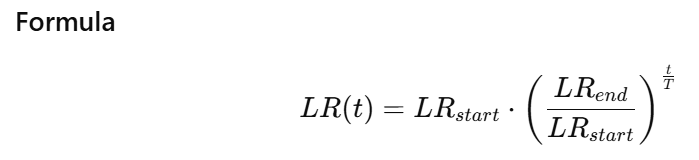

In [ ]:
START_LR=1e-7
END_LR=10
NUM_ITER=100
optimizer=optim.Adam(model.parameters(),lr=START_LR)
criterion=nn.CrossEntropyLoss()
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model=model.to(device)
criterion=criterion.to(device)

In [ ]:
lr_finder=LRFinder(model,optimizer,criterion,device)

In [ ]:
lrs,losses=lr_finder.range_test(train_iterator,END_LR,NUM_ITER)

In [ ]:
def plot_lr_finder(lrs,losses,skip_start=5,skip_end=5):
  if skip_end == 0:
    lrs=lrs[skip_start:]
    losses=losses[skip_start:]
  else:
    lrs=lrs[skip_start:-skip_start]
    losses=losses[skip_start:-skip_end]
  fig=plt.figure(figsize=(16,8))
  ax=fig.add_subplot(1,1,1)
  ax.plot(lrs,losses)
  ax.set_xscale('log')
  ax.set_xlabel('learning rate')
  ax.set_ylabel('loss')
  ax.grid(True,'both','x')
  plt.show()


In [ ]:
len(lrs)

100

In [ ]:
lrs

[1e-07,
 1.202264434617413e-07,
 1.4454397707459274e-07,
 1.7378008287493754e-07,
 2.0892961308540395e-07,
 2.51188643150958e-07,
 3.019951720402016e-07,
 3.6307805477010137e-07,
 4.36515832240166e-07,
 5.248074602497725e-07,
 6.309573444801933e-07,
 7.585775750291837e-07,
 9.120108393559096e-07,
 1.096478196143185e-06,
 1.3182567385564074e-06,
 1.5848931924611132e-06,
 1.9054607179632473e-06,
 2.2908676527677735e-06,
 2.754228703338166e-06,
 3.311311214825911e-06,
 3.981071705534973e-06,
 4.7863009232263826e-06,
 5.754399373371569e-06,
 6.918309709189365e-06,
 8.317637711026708e-06,
 9.999999999999999e-06,
 1.202264434617413e-05,
 1.4454397707459279e-05,
 1.737800828749376e-05,
 2.0892961308540385e-05,
 2.5118864315095795e-05,
 3.019951720402016e-05,
 3.630780547701014e-05,
 4.365158322401661e-05,
 5.248074602497728e-05,
 6.309573444801929e-05,
 7.585775750291836e-05,
 9.120108393559096e-05,
 0.00010964781961431851,
 0.00013182567385564074,
 0.0001584893192461114,
 0.00019054607179632

In [ ]:
len(losses)

100

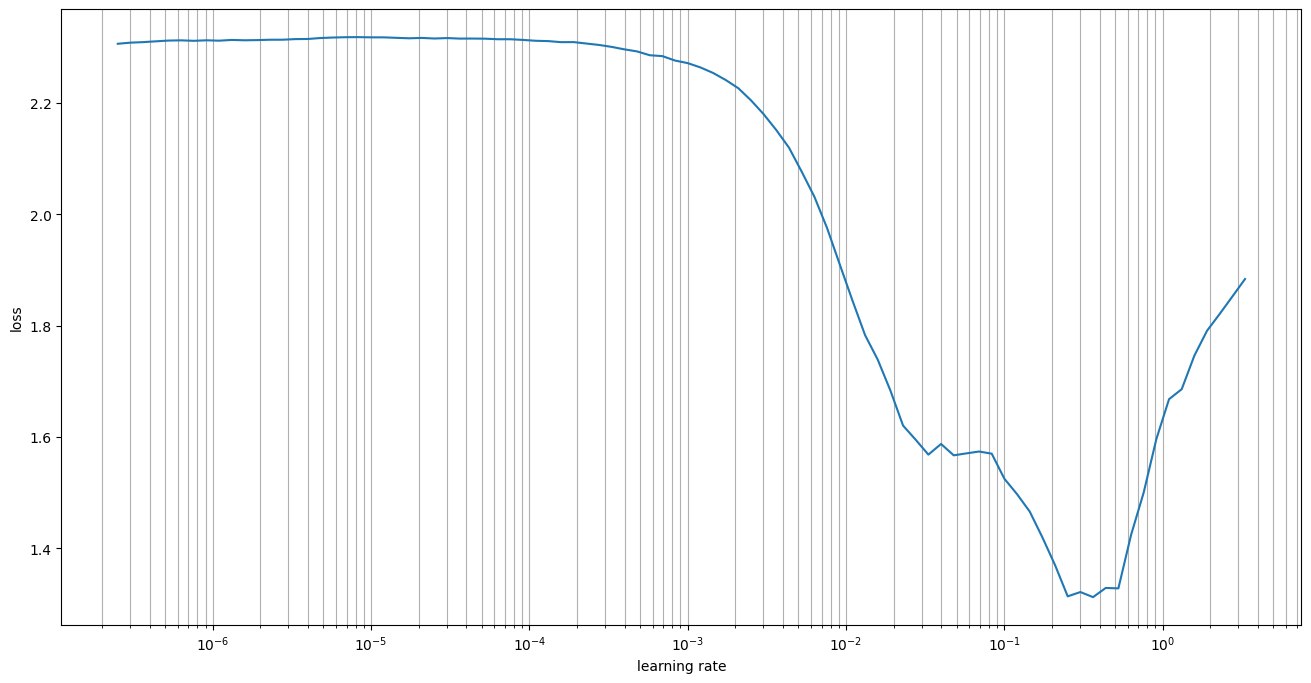

In [ ]:
plot_lr_finder(lrs,losses)